<a href="https://colab.research.google.com/github/mdfirozwadud/alzheimers-detection-cnn/blob/main/Milesstone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from google.colab import files

import tensorflow as tf
from tensorflow import keras


print("All libraries imported successfully!")

All libraries imported successfully!


#**Download Dataset**
We are using the Dataset from the kaggle.
Here is the link: https://www.kaggle.com/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset


In [2]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d marcopinamonti/alzheimer-mri-4-classes-dataset

!unzip alzheimer-mri-4-classes-dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (46).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (47).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (48).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (49).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (5).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (50).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (51).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (52).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (53).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (54).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemen

In [4]:
# Split dataset
source_dir = '/content/dataset/Alzheimer_MRI_4_classes_dataset'
output_dir = '/content/split_dataset'

for cls in os.listdir(source_dir):
    cls_path = os.path.join(source_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    train, temp = train_test_split(images, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.33, random_state=42)

    for split, imgs in [('train', train), ('val', val), ('test', test)]:
        dest = os.path.join(output_dir, split, cls)
        os.makedirs(dest, exist_ok=True)
        for img in imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(dest, img))

print("Dataset split complete (70% train, 20% val, 10% test)")

Dataset split complete (70% train, 20% val, 10% test)


# **Data Visualization Before Preprocessing**

In [5]:
train_dir = f'{output_dir}/train'
classes = sorted(os.listdir(train_dir))
counts = {s: {c: len(os.listdir(f'{output_dir}/{s}/{c}')) for c in classes}
          for s in ['train', 'val', 'test']}

### **Original Dataset: Image Distribution Across Train/Val/Test Splits**

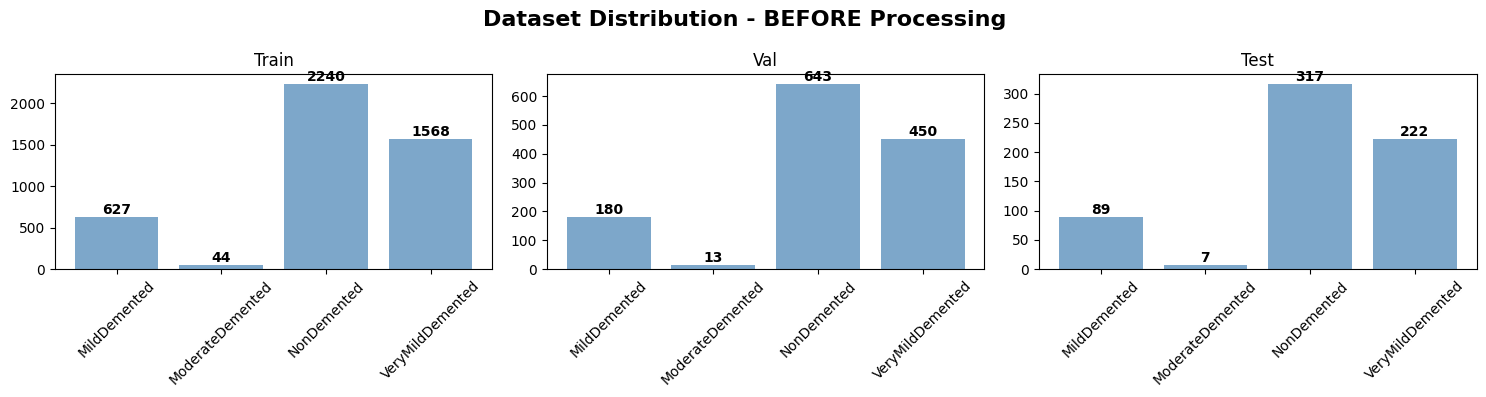

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Dataset Distribution - BEFORE Processing', fontsize=16, fontweight='bold')
for ax, (split, data) in zip(axes, counts.items()):
    bars = ax.bar(data.keys(), data.values(), color='steelblue', alpha=0.7)
    ax.set_title(split.capitalize(), fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h, int(h), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

### **Visual Inspection: Random Samples from Each Class (Original Images)**

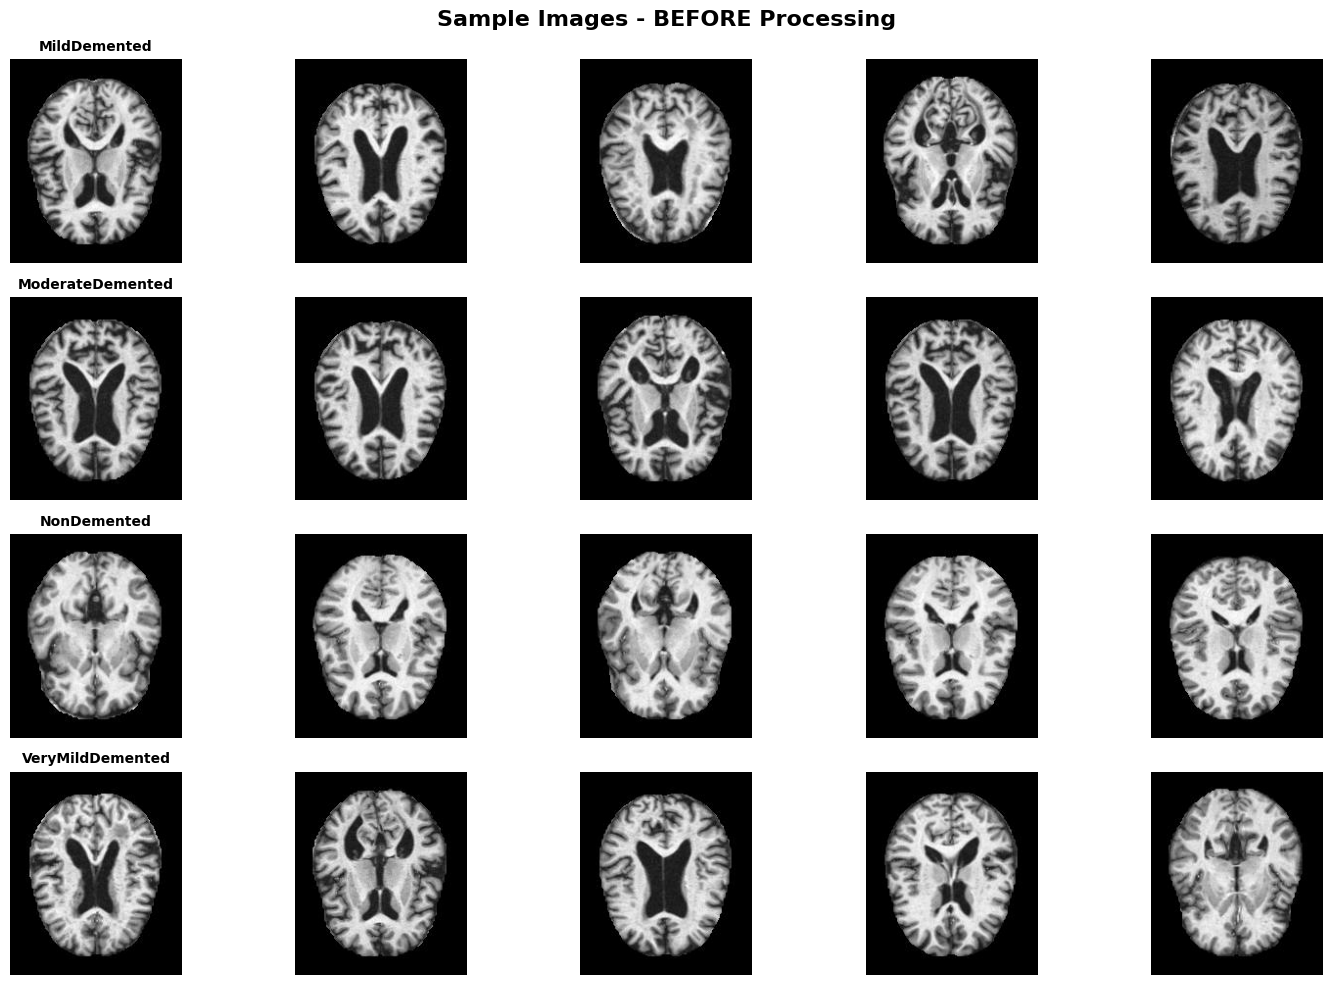

In [7]:
fig, axes = plt.subplots(len(classes), 5, figsize=(15, 10))
fig.suptitle('Sample Images - BEFORE Processing', fontsize=16, fontweight='bold')
for i, cls in enumerate(classes):
    imgs = random.sample(os.listdir(f'{train_dir}/{cls}'), min(5, len(os.listdir(f'{train_dir}/{cls}'))))
    for j, img in enumerate(imgs):
        axes[i, j].imshow(Image.open(f'{train_dir}/{cls}/{img}'), cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(cls, fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

### **Class Balance Analysis: Distribution Across Splits (Before Processing)**

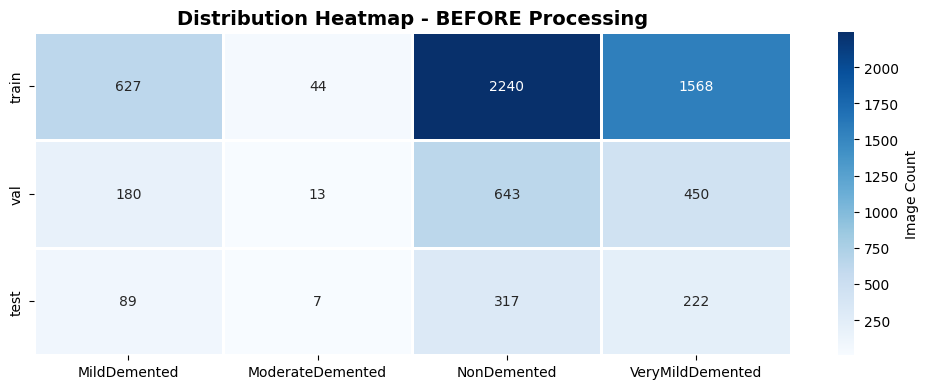

In [8]:
df = pd.DataFrame(counts).T
plt.figure(figsize=(10, 4))
sns.heatmap(df, annot=True, fmt='d', cmap='Blues', linewidths=1, cbar_kws={'label': 'Image Count'})
plt.title('Distribution Heatmap - BEFORE Processing', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### **Dataset Summary Statistics**

In [9]:
print(f"Summary:")
print(f"Total: {df.sum().sum()} images")
print(f"Train: {df.loc['train'].sum()} | Val: {df.loc['val'].sum()} | Test: {df.loc['test'].sum()}")
print(f"Classes: {', '.join(classes)}")

Summary:
Total: 6400 images
Train: 4479 | Val: 1286 | Test: 635
Classes: MildDemented, ModerateDemented, NonDemented, VeryMildDemented


#**Download Split Dataset**

In [10]:
# Download split dataset
zip_path = '/content/split_dataset.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files_list in os.walk(output_dir):
        for file in files_list:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, output_dir))

print(f"Zip created: {os.path.getsize(zip_path) / (1024*1024):.2f} MB")
files.download(zip_path)
print("Download started!")

Zip created: 33.58 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started!


# **Preprocessing and Augmentation**

In [11]:
processed_dir = '/content/processed_dataset'

# aug_datagen = ImageDataGenerator(
#     rescale=1./255,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     fill_mode='nearest'
# )

for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(f'{processed_dir}/{split}/{cls}', exist_ok=True)

        for img_name in os.listdir(f'{output_dir}/{split}/{cls}'):
            # Load, resize, normalize
            img = Image.open(f'{output_dir}/{split}/{cls}/{img_name}').resize((176, 176)).convert('RGB')
            img_array = img_to_array(img) / 255.0

            # Save preprocessed original
            array_to_img(img_array).save(f'{processed_dir}/{split}/{cls}/{img_name}')

            # # Add augmented versions (training only, 2x per image)
            # if split == 'train':
            #     img_array = img_array.reshape((1,) + img_array.shape)
            #     aug_iter = aug_datagen.flow(img_array, batch_size=1)
            #     for i in range(2):
            #         aug_img = array_to_img(next(aug_iter)[0])
            #         aug_img.save(f'{processed_dir}/{split}/{cls}/aug{i}_{img_name}')

print("Preprocessing & augmentation complete!")


Preprocessing & augmentation complete!


# **Exploration and Visualization after Preprocessing**

In [12]:
processed_train_dir = f'{processed_dir}/train'
processed_counts = {s: {c: len(os.listdir(f'{processed_dir}/{s}/{c}')) for c in classes}
                    for s in ['train', 'val', 'test']}

### **Processed Dataset: Image Distribution After Augmentation**

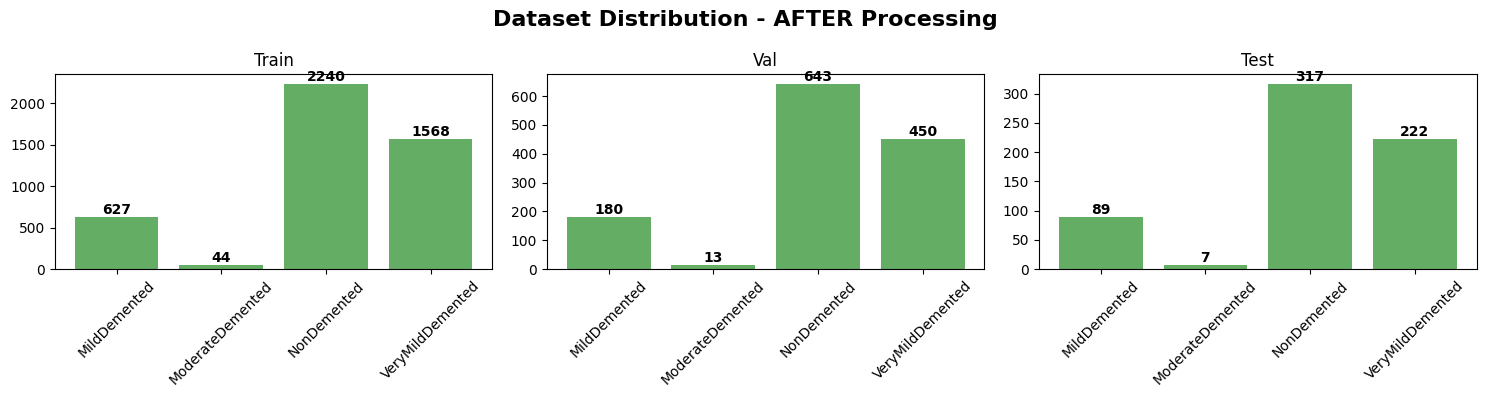

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Dataset Distribution - AFTER Processing', fontsize=16, fontweight='bold')
for ax, (split, data) in zip(axes, processed_counts.items()):
    bars = ax.bar(data.keys(), data.values(), color='forestgreen', alpha=0.7)
    ax.set_title(split.capitalize(), fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h, int(h), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

###**Preprocessed Samples: Preprocessed & Transformed Images (176×176, Normalized)**

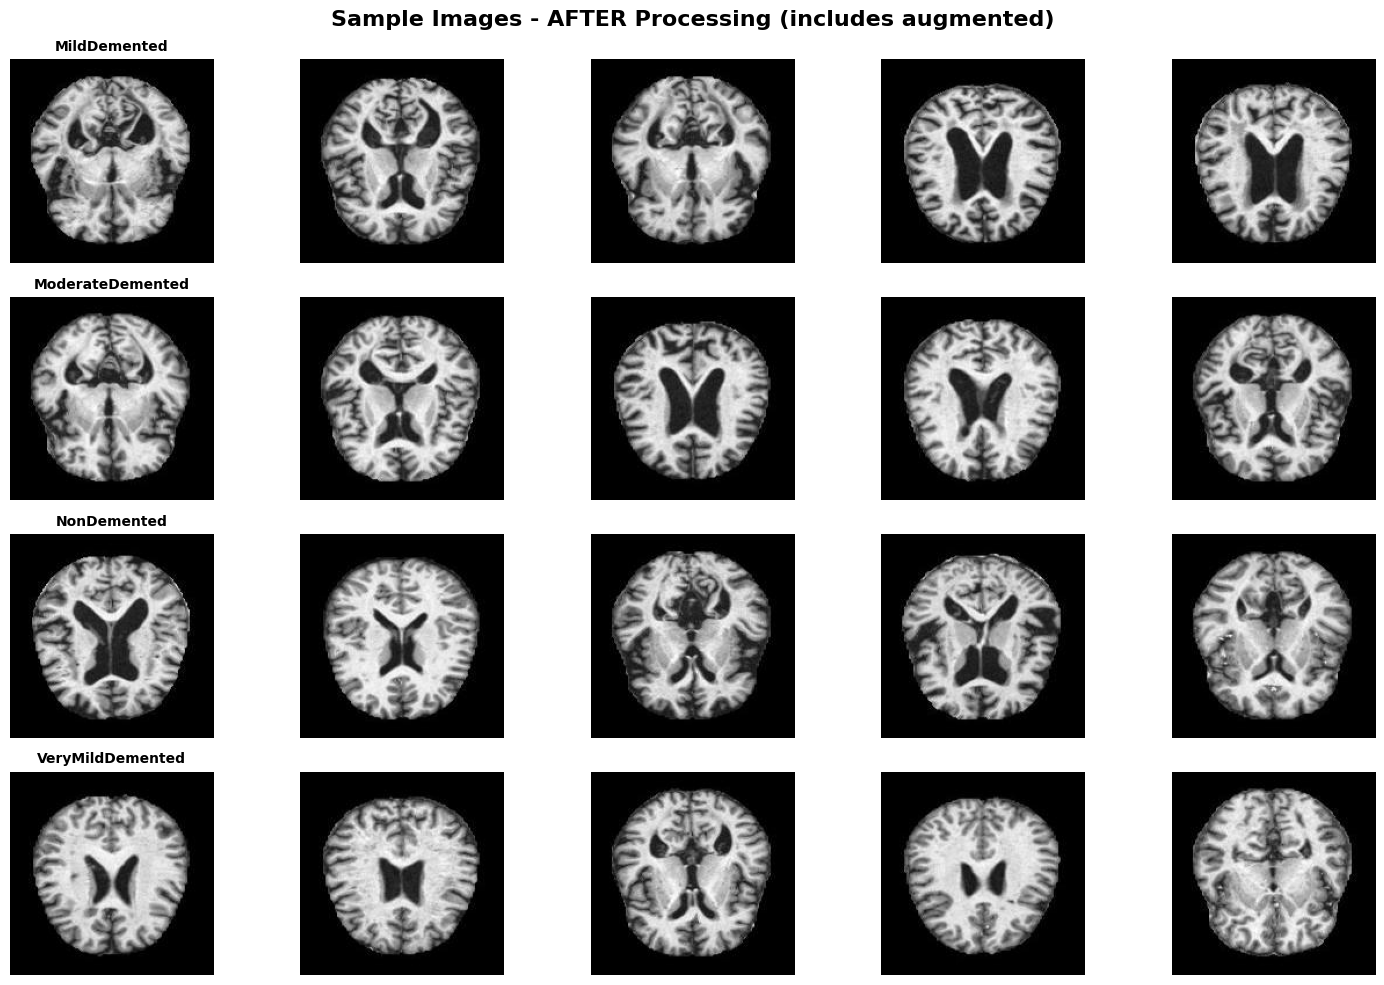

In [14]:
fig, axes = plt.subplots(len(classes), 5, figsize=(15, 10))
fig.suptitle('Sample Images - AFTER Processing (includes augmented)', fontsize=16, fontweight='bold')
for i, cls in enumerate(classes):
    imgs = random.sample(os.listdir(f'{processed_train_dir}/{cls}'), min(5, len(os.listdir(f'{processed_train_dir}/{cls}'))))
    for j, img in enumerate(imgs):
        axes[i, j].imshow(Image.open(f'{processed_train_dir}/{cls}/{img}'))
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(cls, fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

### **Impact of Data Augmentation: Before vs After Comparison**

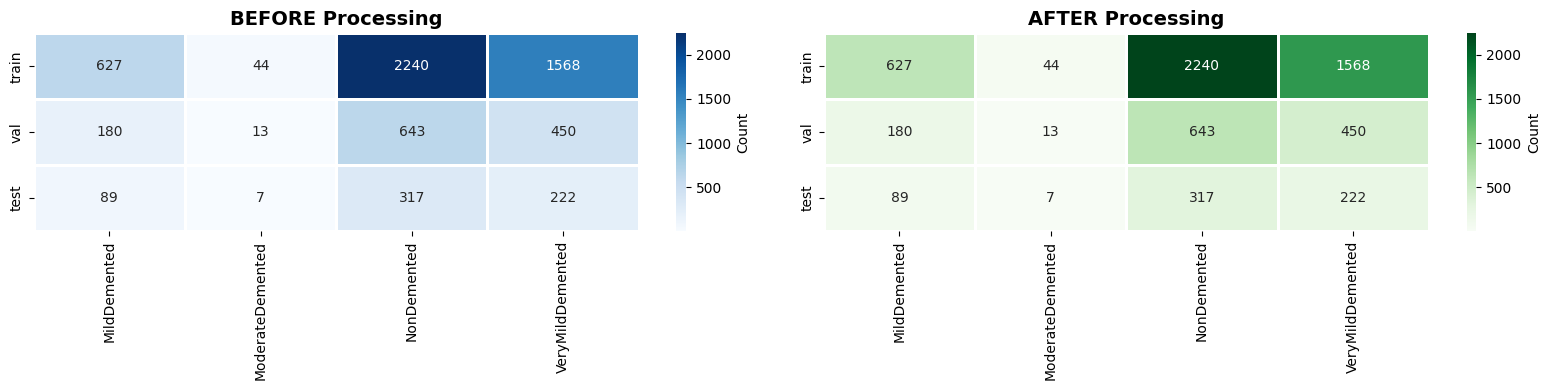

In [15]:
df_before = pd.DataFrame(counts).T
df_after = pd.DataFrame(processed_counts).T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.heatmap(df_before, annot=True, fmt='d', cmap='Blues', linewidths=1, ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title('BEFORE Processing', fontsize=14, fontweight='bold')
sns.heatmap(df_after, annot=True, fmt='d', cmap='Greens', linewidths=1, ax=ax2, cbar_kws={'label': 'Count'})
ax2.set_title('AFTER Processing', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## **Preprocessing Impact Analysis:**

In [16]:

print(f"BEFORE vs AFTER Comparison:")
print(f"{'':20} {'BEFORE':>10} {'AFTER':>10} {'Change':>10}")
print("-" * 55)
for split in ['train', 'val', 'test']:
    before = df_before.loc[split].sum()
    after = df_after.loc[split].sum()
    change = after - before
    print(f"{split.capitalize():20} {before:>10} {after:>10} {'+'+str(change) if change > 0 else str(change):>10}")
print("-" * 55)
print(f"{'Total':20} {df_before.sum().sum():>10} {df_after.sum().sum():>10} {'+'+str(int(df_after.sum().sum() - df_before.sum().sum())):>10}")

BEFORE vs AFTER Comparison:
                         BEFORE      AFTER     Change
-------------------------------------------------------
Train                      4479       4479          0
Val                        1286       1286          0
Test                        635        635          0
-------------------------------------------------------
Total                      6400       6400         +0


# **Download Preprocessed Dataset**

In [17]:
processed_zip_path = '/content/processed_dataset.zip'
with zipfile.ZipFile(processed_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files_list in os.walk(processed_dir):
        for file in files_list:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, processed_dir))

print(f"Processed zip created: {os.path.getsize(processed_zip_path) / (1024*1024):.2f} MB")
files.download(processed_zip_path)
print("Download started!")

Processed zip created: 31.11 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started!


# **Training**

In [18]:
datagen = ImageDataGenerator()
generators = {}

for split in ['train', 'val', 'test']:
    generators[split] = datagen.flow_from_directory(
        f'{processed_dir}/{split}',
        target_size=(176, 176),
        batch_size=32,
        class_mode='categorical',
        shuffle=(split == 'train')
    )

train_generator = generators['train']
val_generator = generators['val']
test_generator = generators['test']

print(f"✓ Data loaded: {train_generator.samples + val_generator.samples + test_generator.samples} images")

Found 4479 images belonging to 4 classes.
Found 1286 images belonging to 4 classes.
Found 635 images belonging to 4 classes.
✓ Data loaded: 6400 images


In [ ]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape = [176,176,3]),
keras.layers.Dense(100, activation = 'relu' ),
keras.layers.Dense(200, activation = 'relu' ),

keras.layers.Dense(200, activation = 'relu' ),

keras.layers.Dense(200, activation = 'relu' ),

keras.layers.Dense(200, activation = 'relu' ),
keras.layers.Dense(4, activation = 'softmax')])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True)

In [ ]:
model.compile(optimizer='adam',
loss=tf.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])

In [ ]:
result = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[callback]
)

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
loss_train = result.history['auc']
loss_val = result.history['val_auc']
epochs = range(len(loss_train))
plt.plot(epochs, loss_train, 'g', label='Training AUC')
plt.plot(epochs, loss_val, 'b', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

In [ ]:
loss_train = result.history['loss']
loss_val = result.history['val_loss']
epochs = range(len(loss_train))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [176,176,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

In [ ]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.AUC(name='auc')]
    )

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    verbose=1,
    callbacks=[callback]
)